In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext line_profiler

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()

import sys
import os

COCO_DATA = 'data/coco/'
MASK_RCNN_MODEL_PATH = 'lib/Mask_RCNN/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config
   
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")



Using TensorFlow backend.


### Dataset

In [2]:
# train_classes = coco_nopascal_classes
one_shot_classes = np.array([4*i + index for i in range(20)])
train_classes = np.array(range(1,81))[np.array([i not in one_shot_classes for i in range(1,81)])]

In [3]:
# Load COCO/val dataset
coco_val = siamese_utils.IndexedCocoDataset()
coco_object = coco_val.load_coco(COCO_DATA, subset="val", year="2017", return_coco=True)
coco_val.prepare()
coco_val.build_indices()
coco_val.ACTIVE_CLASSES = train_classes

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


### Model

In [5]:
class EvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    


In [6]:
config = EvalConfig()    
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_DIR                 checkpoints/
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        30
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EXPERIMENT                     evaluation
FPN_CLASSIF_FC_LAYERS_SIZE     512
FPN_FEATUREMAPS                256
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
LOSS_WEIGHTS                   {'rpn_class_loss': 2.0, 'rpn_bbox_loss': 0.1, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_loss': 0.

In [7]:
# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
train_schedule = OrderedDict()
train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
train_schedule[120] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
train_schedule[160] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}


In [8]:
# Select checkpoint
checkpoint = 'checkpoints/small_siamese_mrcnn_0160.h5'

### Visualization

In [9]:
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
loading checkpoints/small_siamese_mrcnn_0160.h5 ...
starting from epoch 160


image_id 546
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
target                   shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  238.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.80000  max:  142.10000  float64
molded_targets           shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  238.00000  uint8
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


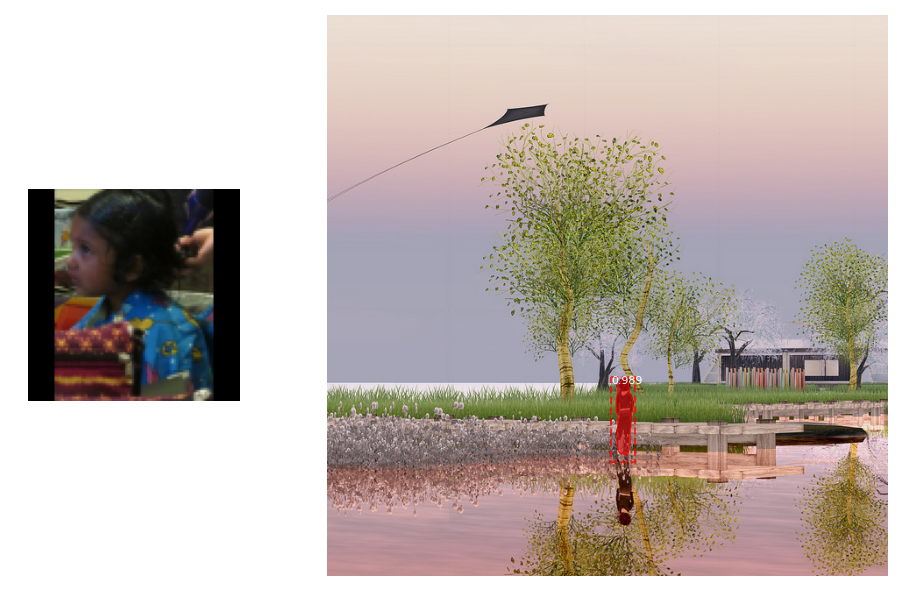

In [13]:
# Select category
category = 1
image_id = np.random.choice(coco_val.category_image_index[category])   
# Load target
target = siamese_utils.get_one_target(category, coco_val, config)
# Load image
image = coco_val.load_image(image_id)
print("image_id", image_id)


# Run detection
results = model.detect([[target]], [image], verbose=1)
r = results[0]
# Display results
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])

In [ ]:
# Select category
category = 1
image_id = np.random.choice(coco_val.category_image_index[category])   
# Load target
target = siamese_utils.get_one_target(category, coco_val, config)
# Load image
image = coco_val.load_image(image_id)
print("image_id", image_id)


# Run detection
results = model.detect([[target]], [image], verbose=1)
r = results[0]
# Display results
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])